In [1]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

nltk.download('stopwords')
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
reviews  = pd.read_csv('/content/drive/My Drive/Reviews.csv',encoding='latin-1')

In [3]:
sample = reviews.loc[0:10000]
sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ..."
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...
9999,10000,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,4,1337472000,The best weve tried so far,We have a 7 week old... He had gas and constip...


if we see the Score column, it has values 1,2,3,4,5 . Considering 1, 2 as Negative reviews and 4, 5 as Positive reviews. For Score = 3 we will consider it as Neutral review and lets delete the rows that are neutral, so that we can predict either Positive or Negative

In [4]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10001 non-null  int64 
 1   ProductId               10001 non-null  object
 2   UserId                  10001 non-null  object
 3   ProfileName             10001 non-null  object
 4   HelpfulnessNumerator    10001 non-null  int64 
 5   HelpfulnessDenominator  10001 non-null  int64 
 6   Score                   10001 non-null  int64 
 7   Time                    10001 non-null  int64 
 8   Summary                 10001 non-null  object
 9   Text                    10001 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.5+ KB


In [0]:
#removing all neutral reviews
sample_score_removed = sample.loc[sample.Score !=3]

In [0]:
#any score above 2 is posetive while others negative
sample_score_removed.Score = sample_score_removed.Score.apply(lambda x : 'Negative' if x<= 2 else 'Posetive')

#Data Cleaning

In [0]:
#removing duplicate values based on UserId,ProfileName,Time,Text
duplicated_values_boollian = sample_score_removed.duplicated(subset={"UserId","ProductId","ProfileName","Time","Text"})
final = sample_score_removed.loc[~duplicated_values_boollian]

In [8]:
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Posetive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Posetive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Posetive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
9996,9997,B000P41A28,A5VVRGL8JA7R,Adam,2,3,Posetive,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ..."
9997,9998,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,Posetive,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...
9998,9999,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,Posetive,1203638400,very convenient,i love the fact that i can get this delieved t...
9999,10000,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,Posetive,1337472000,The best weve tried so far,We have a 7 week old... He had gas and constip...


In [0]:
final_X = final['Text']+ final['Summary'] 
final_y = final['Score']

Converting all words to lowercase and removing punctuations and html tags if any

Stemming- Converting the words into their base word or stem word ( Ex - tastefully, tasty, these words are converted to stem word called 'tasti'). This reduces the vector dimension because we dont consider all similar words

Stopwords - Stopwords are the unnecessary words that even if they are removed the sentiment of the sentence dosent change.

In [10]:
stop = set(stopwords.words('english')) 
print(stop)

{"won't", 'then', 'm', 'are', 'while', 'which', 'those', 'so', 'aren', 'didn', "don't", 'his', 'its', 'through', 'all', "didn't", 're', 'hers', 'on', 'was', 'hadn', "couldn't", 'against', 'under', 'mightn', 'he', 'few', 'yourself', 'wouldn', 'hasn', 'her', 'there', 'will', 'himself', 'theirs', "isn't", 'shan', "shan't", 'once', 'here', "weren't", 'myself', "she's", 'further', 'between', 'doesn', 'same', 'weren', 'been', 'yours', 'when', 'them', 'into', "it's", 'you', 'i', 'needn', 'll', 'but', 'of', 'they', 'this', 'am', 'at', 'themselves', "you'd", 'ourselves', 'yourselves', "you'll", 'because', 'by', 'both', 'some', "mightn't", 'him', 'she', 'an', 'o', 'has', 'other', 'haven', "wasn't", "you've", 'after', 'nor', 'over', "hasn't", 'before', 'me', 'the', "haven't", 'now', 'to', 'again', 'do', 'and', 'ain', 'ma', 'does', 'if', 'too', 's', 'have', 'such', 'own', 'up', 'should', 'not', 'doing', 'my', 't', 'couldn', 'had', 'down', 'out', 'ours', "mustn't", 'herself', 'where', 'during', "sh

In [0]:
def cleaner(sentence):
  import re
  error = []
  snow = nltk.stem.SnowballStemmer('english')
  sentence = sentence.lower()               # Converting to lowercase
  cleanr = re.compile('<.*?>')
  sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
  sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
  return sentence


In [0]:
final_X = final_X.apply(lambda x : cleaner(x))

In [0]:
#removing stopwords and stemming
stemmer = PorterStemmer()
def stemming_n_stop(x):
    text = []
    for word in x.split():
      if word.strip() not in stop:
        word = stemmer.stem(word.strip())
        text.append(word)
    return " ".join(text)      

In [0]:
final_X = final_X.apply(lambda x : stemming_n_stop(x))

In [15]:
final_X

0        bought sever vital can dog food product found ...
1        product arriv label jumbo salt peanut peanut a...
2        confect around centuri light pillowi citru gel...
3        look secret ingredi robitussin believ found go...
4        great taffi great price wide assort yummi taff...
                               ...                        
9996     like bad review say organ formula constip daug...
9997     want sole breastfe unabl keep supplement formu...
9998     love fact get deliev hous delievi charg hard f...
9999     7 week old ga constip problem first 5 week tri...
10000    purchas formula worri read comment 5 month old...
Length: 9131, dtype: object

In [0]:
Final = pd.DataFrame(columns = ['final_X', 'Score'])

In [0]:
Final['final_X'] = final_X
Final['Score'] = final_y

In [18]:
Final

,final_X,Score
0,bought sever vital can dog food product found ...,Posetive
1,product arriv label jumbo salt peanut peanut a...,Negative
2,confect around centuri light pillowi citru gel...,Posetive
3,look secret ingredi robitussin believ found go...,Negative
4,great taffi great price wide assort yummi taff...,Posetive
...,...,...
9996,like bad review say organ formula constip daug...,Posetive
9997,want sole breastfe unabl keep supplement formu...,Posetive
9998,love fact get deliev hous delievi charg hard f...,Posetive
9999,7 week old ga constip problem first 5 week tri...,Posetive


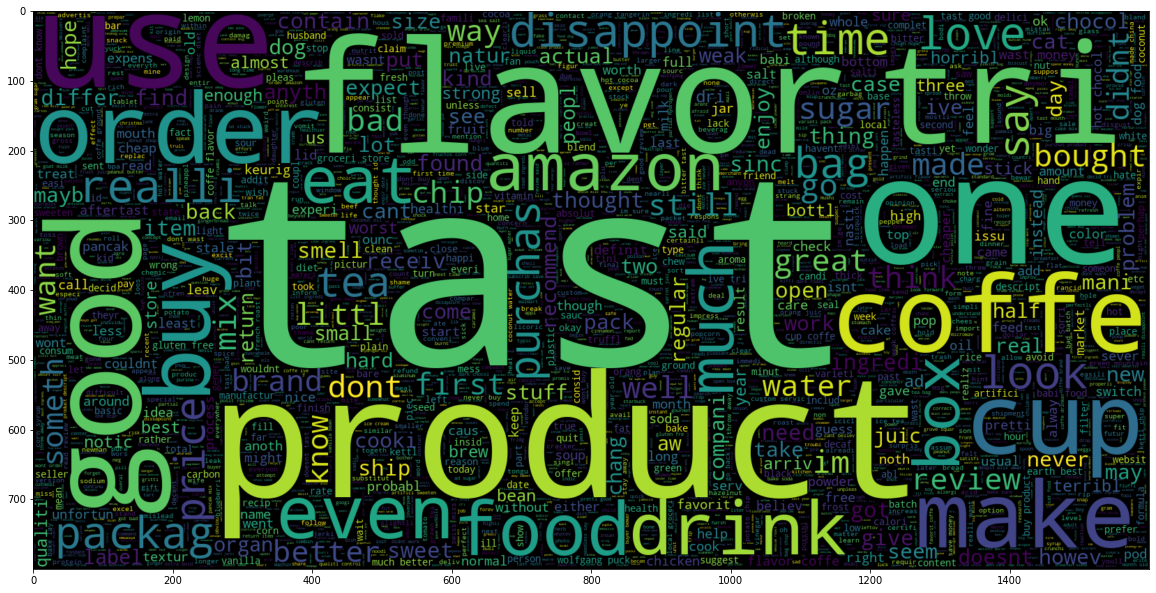

In [19]:
#where reviews are negative
import matplotlib.pyplot as plt
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text with bad/average reviews
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800).generate(" ".join(Final[Final.Score == 'Negative'].final_X))
plt.imshow(wc , interpolation = 'bilinear')

Techniques for Encoding

BAG OF WORDS

In BoW we construct a dictionary that contains set of all unique words from our text review dataset.The frequency of the word is counted here. if there are d unique words in our dictionary then for every sentence or review the vector will be of length d and count of word from review is stored at its particular location in vector. The vector will be highly sparse in such case.

Ex. pasta is tasty and pasta is good

[0]....[1]............[1]...........[2]..........[2]............[1].......... <== Its vector representation ( remaining all dots will be represented as zeroes)

[a]..[and].....[good].......[is].......[pasta]....[tasty]....... <==This is dictionary .

Using scikit-learn's CountVectorizer we can get the BoW and check out all the parameters it consists of, one of them is max_features =5000 it tells about to consider only top 5000 most frequently repeated words to place in a dictionary. so our dictionary length or vector length will be only 5000



In [20]:
count_vect = CountVectorizer(max_features=5000)
bow = count_vect.fit_transform(Final.final_X)
print(bow)

  (0, 587)	1
  (0, 3887)	1
  (0, 4766)	1
  (0, 728)	1
  (0, 1358)	2
  (0, 1773)	2
  (0, 3430)	3
  (0, 1797)	1
  (0, 1948)	2
  (0, 3502)	2
  (0, 2623)	1
  (0, 2581)	1
  (0, 4210)	1
  (0, 3427)	1
  (0, 2744)	1
  (0, 4027)	1
  (0, 496)	2
  (0, 1707)	1
  (0, 307)	1
  (1, 3430)	2
  (1, 328)	1
  (1, 2499)	1
  (1, 2433)	2
  (1, 3773)	1
  (1, 3222)	2
  :	:
  (9130, 3969)	1
  (9130, 2842)	1
  (9130, 4957)	1
  (9130, 4591)	1
  (9130, 2802)	1
  (9130, 3424)	1
  (9130, 4074)	1
  (9130, 3552)	1
  (9130, 4070)	1
  (9130, 2560)	1
  (9130, 3808)	1
  (9130, 3060)	1
  (9130, 12)	1
  (9130, 2872)	1
  (9130, 395)	2
  (9130, 2430)	1
  (9130, 4897)	1
  (9130, 4917)	2
  (9130, 797)	2
  (9130, 4294)	1
  (9130, 4416)	1
  (9130, 967)	1
  (9130, 1025)	3
  (9130, 3223)	1
  (9130, 3461)	2


In [0]:
list_of_sent = []
for i in Final.final_X:
  sent = []
  for word in i.split():
    sent.append(word)
    list_of_sent.append(sent)


BI-GRAM BOW

Considering pair of words for creating dictionary is Bi-Gram , Tri-Gram means three consecutive words so as NGram.

CountVectorizer has a parameter ngram_range if assigned to (1,2) it considers Bi-Gram BoW

But this massively increases our dictionary size

In [0]:
#BiGram approach
cv = CountVectorizer(ngram_range = (1,2),max_features=5000)

In [0]:
#Train test split
x_train,x_test,y_train,y_test = train_test_split(Final.final_X,Final.Score,random_state = 0)

In [26]:
#Transforming training reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (6848, 5000)
BOW_cv_test: (2283, 5000)


In [27]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=0)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,y_train)
print(lr_bow)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [0]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)

In [29]:
#Classification report for bag of words
lr_bow_report=classification_report(y_test,lr_bow_predict)
print(lr_bow_report)

              precision    recall  f1-score   support

    Negative       0.79      0.67      0.72       396
    Posetive       0.93      0.96      0.95      1887

    accuracy                           0.91      2283
   macro avg       0.86      0.81      0.83      2283
weighted avg       0.91      0.91      0.91      2283



In [30]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.9106438896189225
